In [1]:
# Required imports
from __future__ import print_function
from __future__ import division
import pandas as pd  # For storing and manipulation of data files
import numpy as np  
from sklearn.ensemble import RandomForestClassifier # For finding the weights of features
import matplotlib.pyplot as plt  # For plotting figures
import seaborn as sns # To make figures more clear
from sklearn.feature_selection import SelectFromModel # For selecting the important features
from IPython.display import display # Allows the use of display() for DataFrames
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score # metric for model performance
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

%matplotlib inline

### DATA EXPLORATION AND PRE_PROCESSING

In [2]:
# Reading train and test data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
print("Number of rows in the training set : {} and number of features : {}".format(train_data.shape[0],train_data.shape[1]))
print("Number of rows in the testing set  : {} and number of features : {}".format(test_data.shape[0],test_data.shape[1]))

Number of rows in the training set : 76020 and number of features : 371
Number of rows in the testing set  : 75818 and number of features : 370


Features and Target variable in the training set are seperated.ID is just the identifiaction number given to a customer,this variable is also extracted in both training and testing sets.

In [3]:
# Searching for Missing Data
print("Number of Missing values in Training set",train_data.isnull().sum().sum())
print("Number of Missing values in Testing set",test_data.isnull().sum().sum())

Number of Missing values in Training set 0
Number of Missing values in Testing set 0


In [4]:
# selecting the train labels
train_ID = train_data.ID

# Extrating ID and target from the train data and test data
train_data = train_data.drop(labels=["ID"],axis = 1).drop_duplicates()
print("After removing duplicates no of rows in the train data is :",train_data.shape[0])

# Maximum and minimum value in the train data
print("Maximun number in train data :",max(train_data.max()))
print("Minimum amount in train data :",min(train_data.min()))

# Removing these values as they are outliers
for feature in train_data.keys():
    train_data = train_data[train_data[feature] != -999999.00]
    train_data = train_data[train_data[feature] != 9999999999.0]

# Maximum and minimum value in the train data after outliers
print("Maximun number in train data :",max(train_data.max()))
print("Minimum amount in train data :",min(train_data.min()))

After removing duplicates no of rows in the train data is : 71213
Maximun number in train data : 9999999999.0
Minimum amount in train data : -999999.0
Maximun number in train data : 22034738.76
Minimum amount in train data : -4942.26


In [5]:
train_labels = train_data.TARGET
train_features = train_data.drop(labels=["TARGET"],axis = 1)
test_ID = test_data.ID
test_features = test_data.drop("ID",axis = 1)

In [6]:
# Sample structure of the features
train_features.head(5)

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000
1,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000
2,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000
3,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000
4,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016


All the features in the dataset are numerical features.So,there is no need for conversion of categorical data using one hot encoding.
But Number of features are too large for such a small dataset. Feature selection has to be performed to extract important features.

In [7]:
print("Data types and count of features : ",(np.unique(train_features.dtypes,return_counts=True)))

Data types and count of features :  (array([dtype('int64'), dtype('float64')], dtype=object), array([258, 111]))


Values for few columns like var38 is so high.There is a huge differences between 75th percentile and max values.
To avoid model giving high weitage to large values.we should normalize this data.

In [8]:
# Normalize each feature individually
normalized_train_data = pd.DataFrame(normalize(train_features,axis=0))
normalized_test_data = pd.DataFrame(normalize(test_features,axis = 0))

In [9]:
# Now the train data is more normalized.
normalized_train_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,359,360,361,362,363,364,365,366,367,368
count,70571.000000,70571.000000,70571.000000,70571.000000,70571.000000,70571.000000,70571.000000,70571.000000,70571.000000,70571.000000,...,70571.000000,70571.000000,70571.000000,70571.000000,70571.000000,70571.000000,70571.000000,70571.000000,70571.000000,70571.000000
mean,0.001026,0.003508,0.000247,0.000812,0.000832,0.000147,0.000162,0.000053,0.000061,0.000127,...,0.000019,0.000067,0.000047,0.000067,0.000069,0.000045,0.000042,0.000048,0.000052,0.001987
std,0.003622,0.001366,0.003756,0.003676,0.003671,0.003761,0.003761,0.003764,0.003764,0.003762,...,0.003764,0.003764,0.003764,0.003764,0.003764,0.003764,0.003764,0.003764,0.003764,0.003197
min,0.000000,0.000524,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000088
25%,0.000744,0.002412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001117
50%,0.000744,0.002937,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001696
75%,0.000744,0.004195,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002085
max,0.088535,0.011013,0.424061,0.135785,0.137023,0.323879,0.262220,0.782083,0.655506,0.316052,...,0.908818,0.425626,0.648758,0.383341,0.366890,0.833410,0.702056,0.766035,0.692037,0.374267


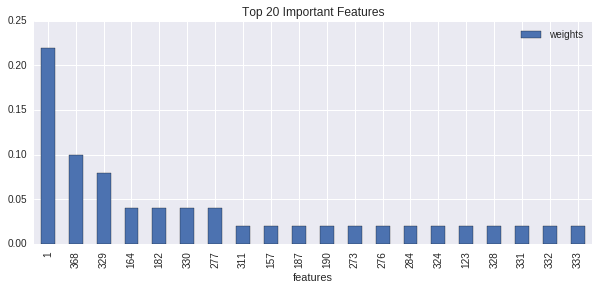

In [10]:
# Using adaboost method for exporting important features
adc = AdaBoostClassifier(n_estimators=50,random_state=50)
adc.fit(normalized_train_data,train_labels)

# Extracting features and corresponding weights
features = normalized_train_data.columns.values
weight_values = adc.feature_importances_

# Forming a data fram with features and corresponsding weights.Add sorting them based on weights
feature_weights = pd.DataFrame({'features':features,'weights':weight_values})
feature_weights.sort_values(['weights'],ascending=False,inplace=True)

# Plotting 20 important features with corresponding weights
top_20_features = feature_weights.head(20)
plt.figure()
top_20_features.plot(x =top_20_features.features,y =1, kind='bar',figsize=(10,4),title='Top 20 Important Features');
plt.savefig("Hello.png")

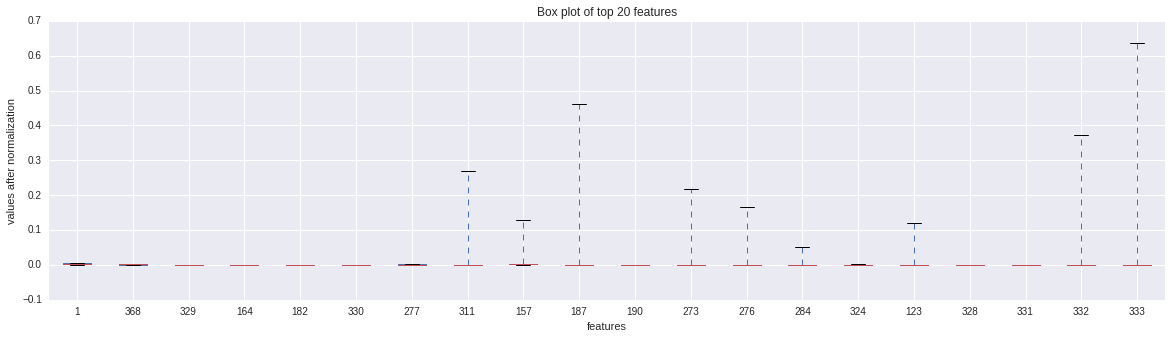

In [11]:
# Box plot of top 20 features 
plt.figure();
ax = normalized_train_data[top_20_features.features].plot(kind = 'box',title = "Box plot of top 20 features",figsize =(20,5));
ax.set_xlabel("features")
ax.set_ylabel("values after normalization")
plt.savefig("Boxplot of 20 features")

In [12]:
print("Data types and count of features : ",(np.unique(normalized_train_data[top_20_features.features].dtypes,return_counts=True)))

Data types and count of features :  (array([dtype('float64')], dtype=object), array([20]))


In [13]:
# Extracting features with overall cumulative weight of 95 percent
weights_cumsum = feature_weights.cumsum()
index_values = weights_cumsum[weights_cumsum.weights <= 0.95].index.tolist()
print("Number of features with 95% cumulative weight :",len(index_values))
top_95_percent_train_features = train_features[train_features.columns[index_values]]
top_95_percent_test_features  = test_features[test_features.columns[index_values]]

print("Shape of train features after future selection :",top_95_percent_train_features.shape)
print("Shape of test features after future selection: ",top_95_percent_test_features.shape)

Number of features with 95% cumulative weight : 26
Shape of train features after future selection : (70571, 26)
Shape of test features after future selection:  (75818, 26)


In [14]:
# Train and Model validation
rf = RandomForestClassifier(random_state=50)
parameters = [{'n_estimators':[100,200,300,400,500,600],'max_depth':range(2,30)}]
clf = GridSearchCV(rf,cv=10,param_grid=parameters,scoring='roc_auc',verbose=3,n_jobs=4)
clf.fit(top_95_percent_train_features,train_labels.values)

Fitting 10 folds for each of 168 candidates, totalling 1680 fits
[CV] n_estimators=100, max_depth=2 ...................................
[CV] n_estimators=100, max_depth=2 ...................................
[CV] n_estimators=100, max_depth=2 ...................................
[CV] n_estimators=100, max_depth=2 ...................................
[CV] .... n_estimators=100, max_depth=2, score=0.766403, total=   4.6s
[CV] n_estimators=100, max_depth=2 ...................................
[CV] .... n_estimators=100, max_depth=2, score=0.748420, total=   4.5s
[CV] n_estimators=100, max_depth=2 ...................................
[CV] .... n_estimators=100, max_depth=2, score=0.756134, total=   4.7s
[CV] n_estimators=100, max_depth=2 ...................................
[CV] .... n_estimators=100, max_depth=2, score=0.770752, total=   4.5s
[CV] n_estimators=100, max_depth=2 ...................................
[CV] .... n_estimators=100, max_depth=2, score=0.789460, total=   4.3s
[CV] n_estim

[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   57.0s


[CV] .... n_estimators=300, max_depth=2, score=0.795410, total=  13.5s
[CV] n_estimators=300, max_depth=2 ...................................
[CV] .... n_estimators=300, max_depth=2, score=0.776133, total=  13.9s
[CV] n_estimators=300, max_depth=2 ...................................
[CV] .... n_estimators=300, max_depth=2, score=0.773706, total=  12.3s
[CV] n_estimators=400, max_depth=2 ...................................
[CV] .... n_estimators=300, max_depth=2, score=0.804969, total=  12.3s
[CV] n_estimators=400, max_depth=2 ...................................
[CV] .... n_estimators=300, max_depth=2, score=0.787594, total=  12.4s
[CV] n_estimators=400, max_depth=2 ...................................
[CV] .... n_estimators=300, max_depth=2, score=0.778735, total=  12.9s
[CV] n_estimators=400, max_depth=2 ...................................
[CV] .... n_estimators=400, max_depth=2, score=0.770456, total=  18.2s
[CV] n_estimators=400, max_depth=2 ...................................
[CV] .

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  9.9min


[CV] .... n_estimators=100, max_depth=4, score=0.775056, total=   6.9s
[CV] n_estimators=100, max_depth=4 ...................................
[CV] .... n_estimators=100, max_depth=4, score=0.806055, total=   6.7s
[CV] n_estimators=100, max_depth=4 ...................................
[CV] .... n_estimators=100, max_depth=4, score=0.800622, total=   6.5s
[CV] n_estimators=100, max_depth=4 ...................................
[CV] .... n_estimators=600, max_depth=3, score=0.804014, total=  32.2s
[CV] n_estimators=100, max_depth=4 ...................................
[CV] .... n_estimators=600, max_depth=3, score=0.788685, total=  32.0s
[CV] n_estimators=100, max_depth=4 ...................................
[CV] .... n_estimators=100, max_depth=4, score=0.817619, total=   6.8s
[CV] n_estimators=100, max_depth=4 ...................................
[CV] .... n_estimators=100, max_depth=4, score=0.800256, total=   6.7s
[CV] n_estimators=200, max_depth=4 ...................................
[CV] .

[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed: 28.7min


[CV] .... n_estimators=500, max_depth=6, score=0.810098, total=  45.8s
[CV] n_estimators=500, max_depth=6 ...................................
[CV] .... n_estimators=500, max_depth=6, score=0.808814, total=  45.5s
[CV] n_estimators=500, max_depth=6 ...................................
[CV] .... n_estimators=500, max_depth=6, score=0.792595, total=  45.6s
[CV] n_estimators=500, max_depth=6 ...................................
[CV] .... n_estimators=500, max_depth=6, score=0.823396, total=  46.6s
[CV] n_estimators=500, max_depth=6 ...................................
[CV] .... n_estimators=500, max_depth=6, score=0.832167, total=  45.6s
[CV] n_estimators=500, max_depth=6 ...................................
[CV] .... n_estimators=500, max_depth=6, score=0.820058, total=  44.8s
[CV] n_estimators=500, max_depth=6 ...................................
[CV] .... n_estimators=500, max_depth=6, score=0.820575, total=  45.7s
[CV] n_estimators=600, max_depth=6 ...................................
[CV] .

[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed: 69.2min


[CV] ... n_estimators=300, max_depth=10, score=0.836522, total=  40.2s
[CV] n_estimators=300, max_depth=10 ..................................
[CV] ... n_estimators=300, max_depth=10, score=0.836667, total=  41.8s
[CV] n_estimators=300, max_depth=10 ..................................
[CV] ... n_estimators=300, max_depth=10, score=0.832701, total=  40.2s
[CV] n_estimators=400, max_depth=10 ..................................
[CV] ... n_estimators=300, max_depth=10, score=0.862015, total=  39.9s
[CV] n_estimators=400, max_depth=10 ..................................
[CV] ... n_estimators=300, max_depth=10, score=0.848477, total=  41.5s
[CV] n_estimators=400, max_depth=10 ..................................
[CV] ... n_estimators=300, max_depth=10, score=0.824786, total=  40.8s
[CV] n_estimators=400, max_depth=10 ..................................
[CV] ... n_estimators=400, max_depth=10, score=0.823788, total=  54.1s
[CV] n_estimators=400, max_depth=10 ..................................
[CV] .

[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 140.7min


[CV] ... n_estimators=200, max_depth=15, score=0.815945, total=  37.0s
[CV] n_estimators=200, max_depth=15 ..................................
[CV] ... n_estimators=200, max_depth=15, score=0.831035, total=  35.4s
[CV] n_estimators=200, max_depth=15 ..................................
[CV] ... n_estimators=200, max_depth=15, score=0.833577, total=  36.3s
[CV] n_estimators=200, max_depth=15 ..................................
[CV] ... n_estimators=200, max_depth=15, score=0.838692, total=  34.5s
[CV] n_estimators=200, max_depth=15 ..................................
[CV] ... n_estimators=200, max_depth=15, score=0.833427, total=  35.4s
[CV] n_estimators=300, max_depth=15 ..................................
[CV] ... n_estimators=200, max_depth=15, score=0.861588, total=  34.6s
[CV] n_estimators=300, max_depth=15 ..................................
[CV] ... n_estimators=200, max_depth=15, score=0.845498, total=  36.2s
[CV] n_estimators=300, max_depth=15 ..................................
[CV] .

[Parallel(n_jobs=4)]: Done 1144 tasks      | elapsed: 247.4min


[CV] ... n_estimators=600, max_depth=20, score=0.847274, total= 2.0min
[CV] n_estimators=100, max_depth=21 ..................................
[CV] ... n_estimators=100, max_depth=21, score=0.824389, total=  19.9s
[CV] n_estimators=100, max_depth=21 ..................................
[CV] ... n_estimators=600, max_depth=20, score=0.817113, total= 2.0min
[CV] n_estimators=200, max_depth=21 ..................................
[CV] ... n_estimators=100, max_depth=21, score=0.845429, total=  20.6s
[CV] n_estimators=200, max_depth=21 ..................................
[CV] ... n_estimators=100, max_depth=21, score=0.836027, total=  20.1s
[CV] n_estimators=200, max_depth=21 ..................................
[CV] ... n_estimators=100, max_depth=21, score=0.808517, total=  19.4s
[CV] n_estimators=200, max_depth=21 ..................................
[CV] ... n_estimators=200, max_depth=21, score=0.817182, total=  40.2s
[CV] n_estimators=200, max_depth=21 ..................................
[CV] .

[Parallel(n_jobs=4)]: Done 1560 tasks      | elapsed: 386.8min


[CV] ... n_estimators=100, max_depth=28, score=0.788585, total=  23.6s
[CV] n_estimators=100, max_depth=28 ..................................
[CV] ... n_estimators=100, max_depth=28, score=0.799907, total=  20.7s
[CV] n_estimators=100, max_depth=28 ..................................
[CV] ... n_estimators=100, max_depth=28, score=0.795742, total=  20.9s
[CV] n_estimators=100, max_depth=28 ..................................
[CV] ... n_estimators=100, max_depth=28, score=0.814541, total=  20.6s
[CV] n_estimators=100, max_depth=28 ..................................
[CV] ... n_estimators=600, max_depth=27, score=0.797976, total= 2.1min
[CV] n_estimators=100, max_depth=28 ..................................
[CV] ... n_estimators=600, max_depth=27, score=0.828176, total= 2.2min
[CV] n_estimators=100, max_depth=28 ..................................
[CV] ... n_estimators=100, max_depth=28, score=0.801983, total=  22.3s
[CV] n_estimators=200, max_depth=28 ..................................
[CV] .

[Parallel(n_jobs=4)]: Done 1680 out of 1680 | elapsed: 428.7min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=50,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid=[{'n_estimators': [100, 200, 300, 400, 500, 600], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=3)

In [15]:
predictions = clf.predict_proba(test_projected_data)

NameError: name 'test_projected_data' is not defined

In [16]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=13, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=600, n_jobs=1, oob_score=False, random_state=50,
            verbose=0, warm_start=False)

In [ ]:
predictions[0]

In [ ]:
type(train_labels)

In [ ]:
test_projected_data.head(3)

In [ ]:
pd.DataFrame({"ID":test_ID.values,"TARGET":predictions[:,1]}).to_csv('submission95Norm.csv',index = False)